In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print("Running on ", device)

# Load the data
FirstData = np.load("cat4gaia.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one and first one
y = FirstData[:, -1]    # The last column
ypreencode = y

# Use LabelEncoder instead of OneHotEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

# Convert y to a PyTorch tensor and move to the GPU (if available)
y = torch.tensor(y, dtype=torch.long).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.cpu().numpy(), test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 150)
        self.fc2 = nn.Linear(150, 200)
        self.fc3 = nn.Linear(200, 150)
        self.fc4 = nn.Linear(150, 60)
        self.fc5 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Calculate class weights
class_counts = np.bincount(y_train_tensor.cpu().numpy())
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
class_weights = torch.tensor(np.clip(class_weights, 0, 100), dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.003)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total

# Training the model with a loading bar, early stopping, and adaptive learning rate
epochs = 200
early_stopping = EarlyStopping(patience=20, min_delta=0.001)
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    scheduler.step(val_loss)  # Step the scheduler
    print(f'\nValidation Loss after Epoch {epoch+1}: {val_loss:.4f}')

    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')


Running on  cpu


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/200: 100%|██████████| 1347/1347 [00:08<00:00, 163.30batch/s, Loss=0.5121]



Validation Loss after Epoch 1: 0.4183
Test Accuracy after Epoch 1: 0.9130


Epoch 2/200: 100%|██████████| 1347/1347 [00:08<00:00, 152.43batch/s, Loss=0.4158]



Validation Loss after Epoch 2: 0.4186
Test Accuracy after Epoch 2: 0.8717


Epoch 3/200: 100%|██████████| 1347/1347 [00:08<00:00, 160.14batch/s, Loss=0.3854]



Validation Loss after Epoch 3: 0.4231
Test Accuracy after Epoch 3: 0.8979


Epoch 4/200: 100%|██████████| 1347/1347 [00:08<00:00, 160.31batch/s, Loss=0.3678]



Validation Loss after Epoch 4: 0.3807
Test Accuracy after Epoch 4: 0.8803


Epoch 5/200: 100%|██████████| 1347/1347 [00:10<00:00, 131.82batch/s, Loss=0.3589]



Validation Loss after Epoch 5: 0.3594
Test Accuracy after Epoch 5: 0.9093


Epoch 6/200: 100%|██████████| 1347/1347 [00:09<00:00, 139.57batch/s, Loss=0.3486]



Validation Loss after Epoch 6: 0.4383
Test Accuracy after Epoch 6: 0.9056


Epoch 7/200: 100%|██████████| 1347/1347 [00:10<00:00, 134.35batch/s, Loss=0.3425]



Validation Loss after Epoch 7: 0.3586
Test Accuracy after Epoch 7: 0.9087


Epoch 8/200: 100%|██████████| 1347/1347 [00:09<00:00, 139.69batch/s, Loss=0.3343]



Validation Loss after Epoch 8: 0.3457
Test Accuracy after Epoch 8: 0.9189


Epoch 9/200: 100%|██████████| 1347/1347 [00:09<00:00, 134.96batch/s, Loss=0.3284]



Validation Loss after Epoch 9: 0.3568
Test Accuracy after Epoch 9: 0.9051


Epoch 10/200: 100%|██████████| 1347/1347 [00:09<00:00, 139.05batch/s, Loss=0.3248]



Validation Loss after Epoch 10: 0.3566
Test Accuracy after Epoch 10: 0.9235


Epoch 11/200: 100%|██████████| 1347/1347 [00:09<00:00, 138.87batch/s, Loss=0.3172]



Validation Loss after Epoch 11: 0.3458
Test Accuracy after Epoch 11: 0.9212


Epoch 12/200: 100%|██████████| 1347/1347 [00:09<00:00, 139.16batch/s, Loss=0.3124]



Validation Loss after Epoch 12: 0.3416
Test Accuracy after Epoch 12: 0.9014


Epoch 13/200: 100%|██████████| 1347/1347 [00:09<00:00, 140.96batch/s, Loss=0.3136]



Validation Loss after Epoch 13: 0.3620
Test Accuracy after Epoch 13: 0.9104


Epoch 14/200: 100%|██████████| 1347/1347 [00:10<00:00, 133.66batch/s, Loss=0.3088]



Validation Loss after Epoch 14: 0.3505
Test Accuracy after Epoch 14: 0.9096


Epoch 15/200: 100%|██████████| 1347/1347 [00:10<00:00, 134.49batch/s, Loss=0.3052]



Validation Loss after Epoch 15: 0.3372
Test Accuracy after Epoch 15: 0.9131


Epoch 16/200: 100%|██████████| 1347/1347 [00:10<00:00, 131.74batch/s, Loss=0.3017]



Validation Loss after Epoch 16: 0.3705
Test Accuracy after Epoch 16: 0.9077


Epoch 17/200: 100%|██████████| 1347/1347 [00:09<00:00, 134.73batch/s, Loss=0.3011]



Validation Loss after Epoch 17: 0.3372
Test Accuracy after Epoch 17: 0.9232


Epoch 18/200: 100%|██████████| 1347/1347 [00:09<00:00, 137.82batch/s, Loss=0.2958]



Validation Loss after Epoch 18: 0.3415
Test Accuracy after Epoch 18: 0.9022


Epoch 19/200: 100%|██████████| 1347/1347 [00:09<00:00, 137.54batch/s, Loss=0.3004]



Validation Loss after Epoch 19: 0.3382
Test Accuracy after Epoch 19: 0.9030


Epoch 20/200: 100%|██████████| 1347/1347 [00:09<00:00, 139.57batch/s, Loss=0.2928]



Validation Loss after Epoch 20: 0.3580
Test Accuracy after Epoch 20: 0.9326


Epoch 21/200: 100%|██████████| 1347/1347 [00:10<00:00, 133.66batch/s, Loss=0.2906]



Validation Loss after Epoch 21: 0.3412
Test Accuracy after Epoch 21: 0.9131


Epoch 22/200: 100%|██████████| 1347/1347 [00:10<00:00, 130.68batch/s, Loss=0.2411]



Validation Loss after Epoch 22: 0.3081
Test Accuracy after Epoch 22: 0.9171


Epoch 23/200: 100%|██████████| 1347/1347 [00:10<00:00, 134.27batch/s, Loss=0.2272]



Validation Loss after Epoch 23: 0.3092
Test Accuracy after Epoch 23: 0.9157


Epoch 24/200: 100%|██████████| 1347/1347 [00:10<00:00, 131.52batch/s, Loss=0.2193]



Validation Loss after Epoch 24: 0.3176
Test Accuracy after Epoch 24: 0.9237


Epoch 25/200: 100%|██████████| 1347/1347 [00:10<00:00, 134.09batch/s, Loss=0.2142]



Validation Loss after Epoch 25: 0.3151
Test Accuracy after Epoch 25: 0.9142


Epoch 26/200: 100%|██████████| 1347/1347 [00:10<00:00, 134.29batch/s, Loss=0.2096]



Validation Loss after Epoch 26: 0.3198
Test Accuracy after Epoch 26: 0.9258


Epoch 27/200: 100%|██████████| 1347/1347 [00:09<00:00, 136.02batch/s, Loss=0.1996]



Validation Loss after Epoch 27: 0.3182
Test Accuracy after Epoch 27: 0.9199


Epoch 28/200: 100%|██████████| 1347/1347 [00:09<00:00, 136.86batch/s, Loss=0.1973]



Validation Loss after Epoch 28: 0.3201
Test Accuracy after Epoch 28: 0.9218


Epoch 29/200: 100%|██████████| 1347/1347 [00:09<00:00, 136.02batch/s, Loss=0.1956]



Validation Loss after Epoch 29: 0.3210
Test Accuracy after Epoch 29: 0.9216


Epoch 30/200: 100%|██████████| 1347/1347 [00:10<00:00, 130.40batch/s, Loss=0.1951]



Validation Loss after Epoch 30: 0.3211
Test Accuracy after Epoch 30: 0.9222


Epoch 31/200: 100%|██████████| 1347/1347 [00:10<00:00, 130.95batch/s, Loss=0.1942]



Validation Loss after Epoch 31: 0.3213
Test Accuracy after Epoch 31: 0.9222


Epoch 32/200: 100%|██████████| 1347/1347 [00:10<00:00, 133.38batch/s, Loss=0.1935]



Validation Loss after Epoch 32: 0.3215
Test Accuracy after Epoch 32: 0.9221


Epoch 33/200: 100%|██████████| 1347/1347 [00:10<00:00, 129.21batch/s, Loss=0.1936]



Validation Loss after Epoch 33: 0.3217
Test Accuracy after Epoch 33: 0.9224


Epoch 34/200: 100%|██████████| 1347/1347 [00:09<00:00, 134.93batch/s, Loss=0.1945]



Validation Loss after Epoch 34: 0.3218
Test Accuracy after Epoch 34: 0.9222


Epoch 35/200: 100%|██████████| 1347/1347 [00:10<00:00, 133.09batch/s, Loss=0.1930]



Validation Loss after Epoch 35: 0.3218
Test Accuracy after Epoch 35: 0.9222


Epoch 36/200: 100%|██████████| 1347/1347 [00:10<00:00, 127.76batch/s, Loss=0.1929]



Validation Loss after Epoch 36: 0.3219
Test Accuracy after Epoch 36: 0.9222


Epoch 37/200: 100%|██████████| 1347/1347 [00:09<00:00, 135.54batch/s, Loss=0.1937]



Validation Loss after Epoch 37: 0.3219
Test Accuracy after Epoch 37: 0.9222


Epoch 38/200: 100%|██████████| 1347/1347 [00:10<00:00, 134.38batch/s, Loss=0.1939]



Validation Loss after Epoch 38: 0.3219
Test Accuracy after Epoch 38: 0.9222


Epoch 39/200: 100%|██████████| 1347/1347 [00:09<00:00, 136.98batch/s, Loss=0.1936]



Validation Loss after Epoch 39: 0.3219
Test Accuracy after Epoch 39: 0.9222


Epoch 40/200: 100%|██████████| 1347/1347 [00:09<00:00, 134.78batch/s, Loss=0.1935]



Validation Loss after Epoch 40: 0.3219
Test Accuracy after Epoch 40: 0.9222


Epoch 41/200: 100%|██████████| 1347/1347 [00:10<00:00, 128.87batch/s, Loss=0.1933]



Validation Loss after Epoch 41: 0.3219
Test Accuracy after Epoch 41: 0.9222


Epoch 42/200: 100%|██████████| 1347/1347 [00:10<00:00, 131.79batch/s, Loss=0.1935]



Validation Loss after Epoch 42: 0.3219
Early stopping


Classification Report:
               precision    recall  f1-score   support

         Ev*       1.00      0.93      0.96    108258
         MS*       0.42      0.90      0.57      3696
         Ma*       0.21      0.78      0.33       400
         Y*O       0.48      0.90      0.62      2575

    accuracy                           0.93    114929
   macro avg       0.53      0.88      0.62    114929
weighted avg       0.96      0.93      0.94    114929



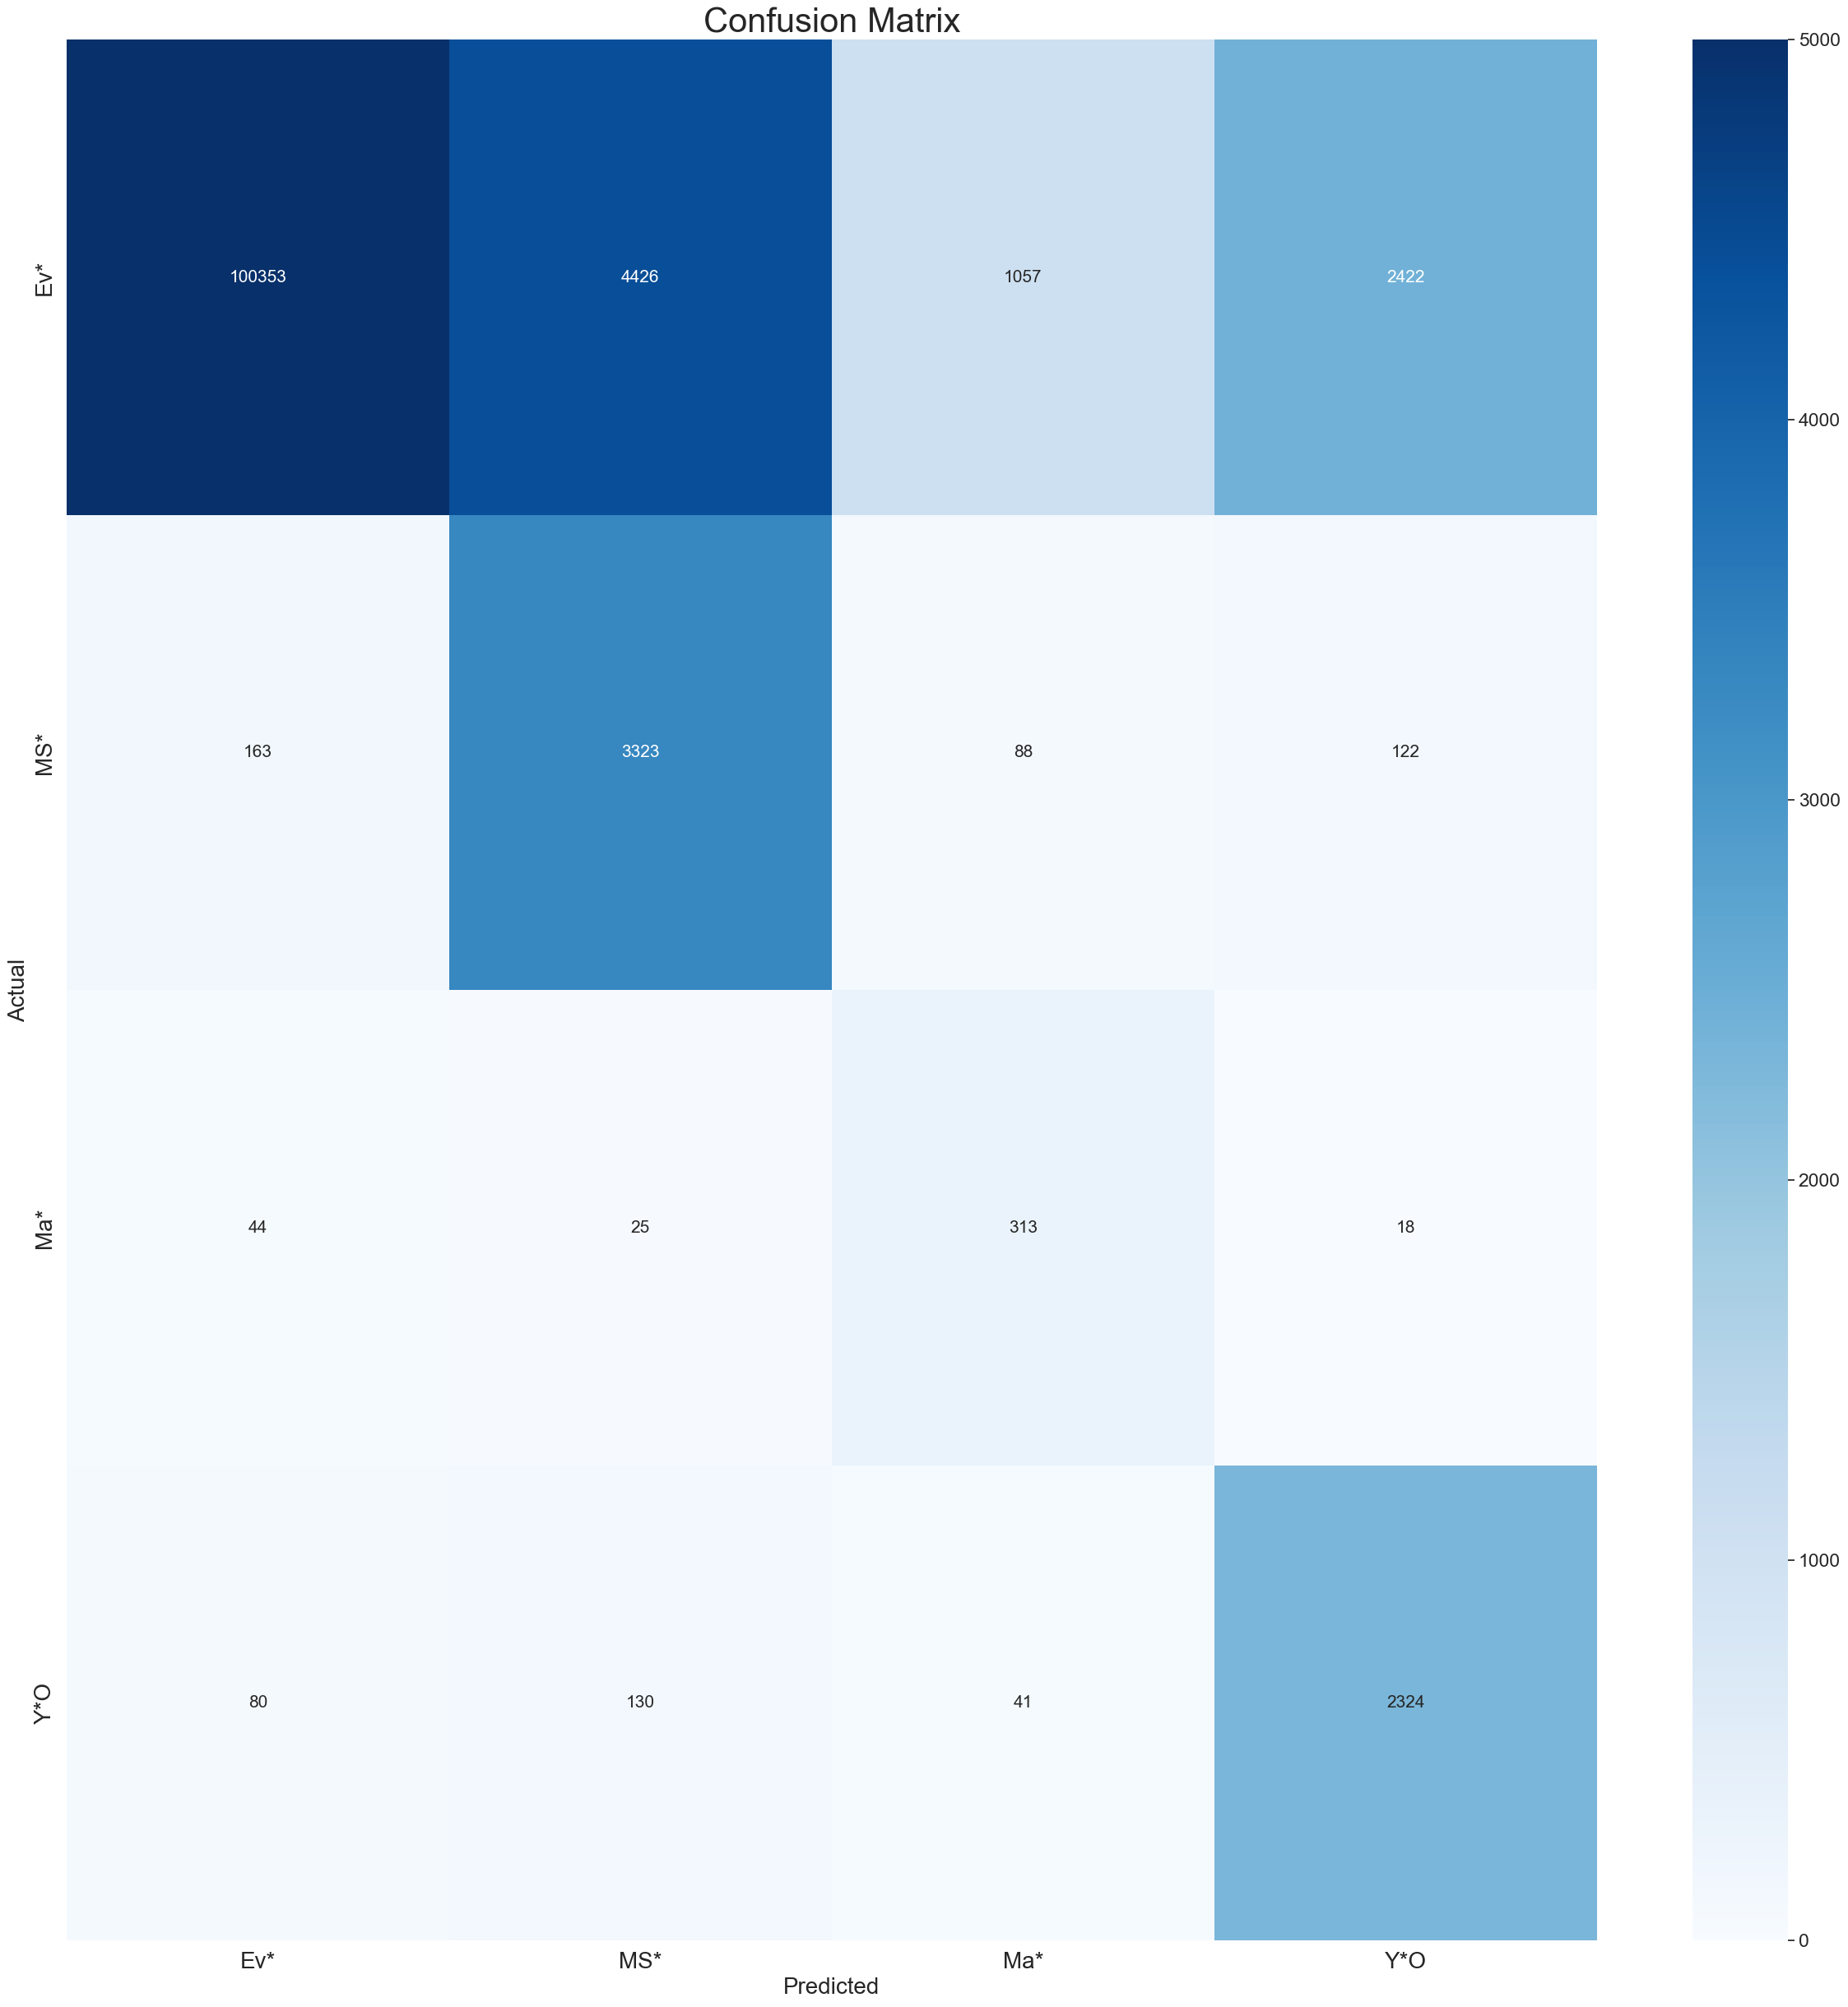

In [9]:
# Load the saved model
#model = NeuralNetwork(input_size, output_size).to(device)
#model.load_state_dict(torch.load('star_classifier_Exp2.pth'))
model.to(device)

# Make predictions on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        # _, labels = torch.max(y_batch.data, 1)  # Remove this line
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())  # Just use y_batch directly

# Get the unique labels from your predictions and true labels
unique_labels = np.unique(all_labels)

# Print the classification report for accuracy per category
report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=encoder.classes_[unique_labels])
print("Classification Report:\n", report)


# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=5000, 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, 
            annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
